# Matplotlib
- great deal of functionality. 
- publication quality
- look at [examples](http://matplotlib.org/examples/index.html) and the [gallery](http://matplotlib.org/gallery.html)
- basically a clone of Matlab graphics

In [23]:
# IMPORTANT - tells matplotlib to insert graphics into the notebook,
# instead opening an external window, which is usually annoying.

%matplotlib inline

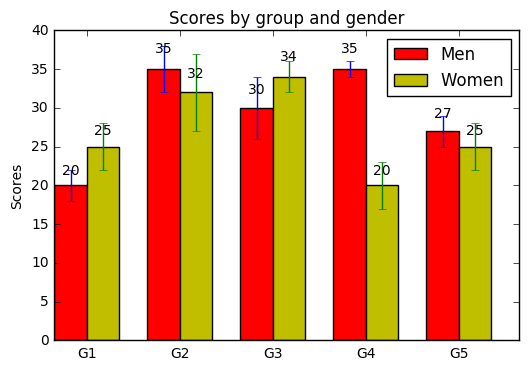

In [14]:
# a bar plot with errorbars

import numpy as np
import matplotlib.pyplot as plt

N = 5
menMeans = (20, 35, 30, 35, 27)
menStd = (2, 3, 4, 1, 2)

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, menMeans, width, color='r', yerr=menStd)

womenMeans = (25, 32, 34, 20, 25)
womenStd = (3, 5, 2, 3, 3)
rects2 = ax.bar(ind + width, womenMeans, width, color='y', yerr=womenStd)

# add some text for labels, title and axes ticks
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(ind + width)
ax.set_xticklabels(('G1', 'G2', 'G3', 'G4', 'G5'))

ax.legend((rects1[0], rects2[0]), ('Men', 'Women'))


def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()


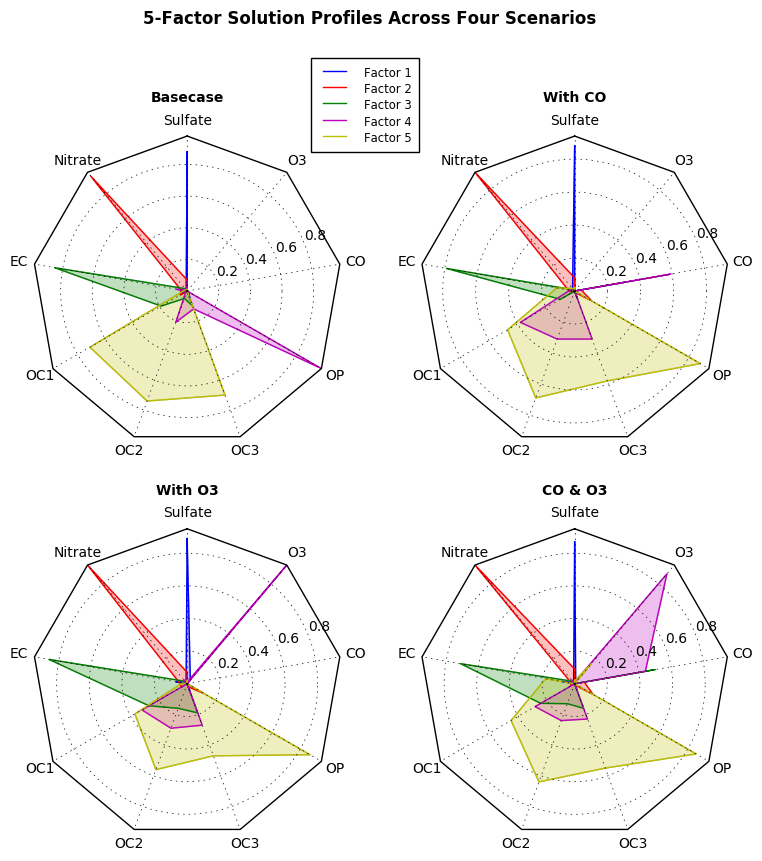

In [15]:
"""
Example of creating a radar chart (a.k.a. a spider or star chart) [1]_.

Although this example allows a frame of either 'circle' or 'polygon', polygon
frames don't have proper gridlines (the lines are circles instead of polygons).
It's possible to get a polygon grid by setting GRIDLINE_INTERPOLATION_STEPS in
matplotlib.axis to the desired number of vertices, but the orientation of the
polygon is not aligned with the radial axes.

.. [1] http://en.wikipedia.org/wiki/Radar_chart
"""
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection


def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)
    # rotate theta such that the first axis is at the top
    theta += np.pi/2

    def draw_poly_patch(self):
        verts = unit_poly_verts(theta)
        return plt.Polygon(verts, closed=True, edgecolor='k')

    def draw_circle_patch(self):
        # unit circle centered on (0.5, 0.5)
        return plt.Circle((0.5, 0.5), 0.5)

    patch_dict = {'polygon': draw_poly_patch, 'circle': draw_circle_patch}
    if frame not in patch_dict:
        raise ValueError('unknown value for `frame`: %s' % frame)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1
        # define draw_frame method
        draw_patch = patch_dict[frame]

        def fill(self, *args, **kwargs):
            """Override fill so that line is closed by default"""
            closed = kwargs.pop('closed', True)
            return super(RadarAxes, self).fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super(RadarAxes, self).plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            return self.draw_patch()

        def _gen_axes_spines(self):
            if frame == 'circle':
                return PolarAxes._gen_axes_spines(self)
            # The following is a hack to get the spines (i.e. the axes frame)
            # to draw correctly for a polygon frame.

            # spine_type must be 'left', 'right', 'top', 'bottom', or `circle`.
            spine_type = 'circle'
            verts = unit_poly_verts(theta)
            # close off polygon by repeating first vertex
            verts.append(verts[0])
            path = Path(verts)

            spine = Spine(self, spine_type, path)
            spine.set_transform(self.transAxes)
            return {'polar': spine}

    register_projection(RadarAxes)
    return theta


def unit_poly_verts(theta):
    """Return vertices of polygon for subplot axes.

    This polygon is circumscribed by a unit circle centered at (0.5, 0.5)
    """
    x0, y0, r = [0.5] * 3
    verts = [(r*np.cos(t) + x0, r*np.sin(t) + y0) for t in theta]
    return verts


def example_data():
    # The following data is from the Denver Aerosol Sources and Health study.
    # See  doi:10.1016/j.atmosenv.2008.12.017
    #
    # The data are pollution source profile estimates for five modeled
    # pollution sources (e.g., cars, wood-burning, etc) that emit 7-9 chemical
    # species. The radar charts are experimented with here to see if we can
    # nicely visualize how the modeled source profiles change across four
    # scenarios:
    #  1) No gas-phase species present, just seven particulate counts on
    #     Sulfate
    #     Nitrate
    #     Elemental Carbon (EC)
    #     Organic Carbon fraction 1 (OC)
    #     Organic Carbon fraction 2 (OC2)
    #     Organic Carbon fraction 3 (OC3)
    #     Pyrolized Organic Carbon (OP)
    #  2)Inclusion of gas-phase specie carbon monoxide (CO)
    #  3)Inclusion of gas-phase specie ozone (O3).
    #  4)Inclusion of both gas-phase speciesis present...
    data = [
        ['Sulfate', 'Nitrate', 'EC', 'OC1', 'OC2', 'OC3', 'OP', 'CO', 'O3'],
        ('Basecase', [
            [0.88, 0.01, 0.03, 0.03, 0.00, 0.06, 0.01, 0.00, 0.00],
            [0.07, 0.95, 0.04, 0.05, 0.00, 0.02, 0.01, 0.00, 0.00],
            [0.01, 0.02, 0.85, 0.19, 0.05, 0.10, 0.00, 0.00, 0.00],
            [0.02, 0.01, 0.07, 0.01, 0.21, 0.12, 0.98, 0.00, 0.00],
            [0.01, 0.01, 0.02, 0.71, 0.74, 0.70, 0.00, 0.00, 0.00]]),
        ('With CO', [
            [0.88, 0.02, 0.02, 0.02, 0.00, 0.05, 0.00, 0.05, 0.00],
            [0.08, 0.94, 0.04, 0.02, 0.00, 0.01, 0.12, 0.04, 0.00],
            [0.01, 0.01, 0.79, 0.10, 0.00, 0.05, 0.00, 0.31, 0.00],
            [0.00, 0.02, 0.03, 0.38, 0.31, 0.31, 0.00, 0.59, 0.00],
            [0.02, 0.02, 0.11, 0.47, 0.69, 0.58, 0.88, 0.00, 0.00]]),
        ('With O3', [
            [0.89, 0.01, 0.07, 0.00, 0.00, 0.05, 0.00, 0.00, 0.03],
            [0.07, 0.95, 0.05, 0.04, 0.00, 0.02, 0.12, 0.00, 0.00],
            [0.01, 0.02, 0.86, 0.27, 0.16, 0.19, 0.00, 0.00, 0.00],
            [0.01, 0.03, 0.00, 0.32, 0.29, 0.27, 0.00, 0.00, 0.95],
            [0.02, 0.00, 0.03, 0.37, 0.56, 0.47, 0.87, 0.00, 0.00]]),
        ('CO & O3', [
            [0.87, 0.01, 0.08, 0.00, 0.00, 0.04, 0.00, 0.00, 0.01],
            [0.09, 0.95, 0.02, 0.03, 0.00, 0.01, 0.13, 0.06, 0.00],
            [0.01, 0.02, 0.71, 0.24, 0.13, 0.16, 0.00, 0.50, 0.00],
            [0.01, 0.03, 0.00, 0.28, 0.24, 0.23, 0.00, 0.44, 0.88],
            [0.02, 0.00, 0.18, 0.45, 0.64, 0.55, 0.86, 0.00, 0.16]])
    ]
    return data


if __name__ == '__main__':
    N = 9
    theta = radar_factory(N, frame='polygon')

    data = example_data()
    spoke_labels = data.pop(0)

    fig = plt.figure(figsize=(9, 9))
    fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

    colors = ['b', 'r', 'g', 'm', 'y']
    # Plot the four cases from the example data on separate axes
    for n, (title, case_data) in enumerate(data):
        ax = fig.add_subplot(2, 2, n + 1, projection='radar')
        plt.rgrids([0.2, 0.4, 0.6, 0.8])
        ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                     horizontalalignment='center', verticalalignment='center')
        for d, color in zip(case_data, colors):
            ax.plot(theta, d, color=color)
            ax.fill(theta, d, facecolor=color, alpha=0.25)
        ax.set_varlabels(spoke_labels)

    # add legend relative to top-left plot
    plt.subplot(2, 2, 1)
    labels = ('Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5')
    legend = plt.legend(labels, loc=(0.9, .95), labelspacing=0.1)
    plt.setp(legend.get_texts(), fontsize='small')

    plt.figtext(0.5, 0.965, '5-Factor Solution Profiles Across Four Scenarios',
                ha='center', color='black', weight='bold', size='large')
    plt.show()


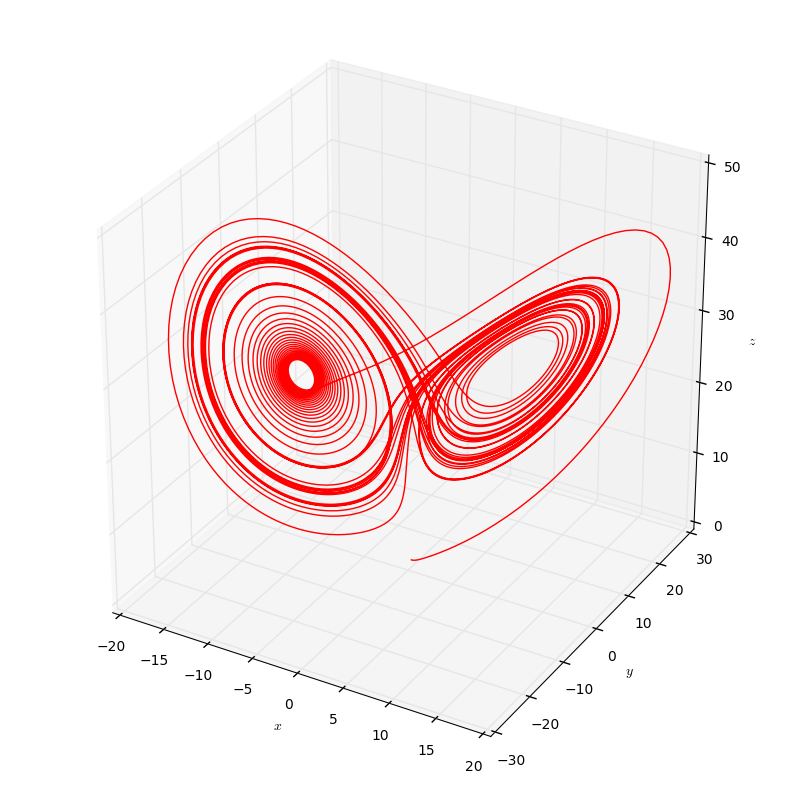

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

def make_lorenz(sigma, r, b):
    def func(statevec, t):
        x, y, z = statevec
        return [ sigma * (y - x), r * x - y - x * z, x * y - b*z]
    return func

lorenz_eq = make_lorenz(10., 28., 8./3.)
tmax = 50
tdelta = 0.005
tvalues = np.arange(0, tmax, tdelta)
ic = np.array([0.0, 1.0, 0.0])
sol = odeint(lorenz_eq, ic, tvalues)
x, y, z = np.array(list(zip(*sol)))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, lw=1, color='red')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')
plt.show()


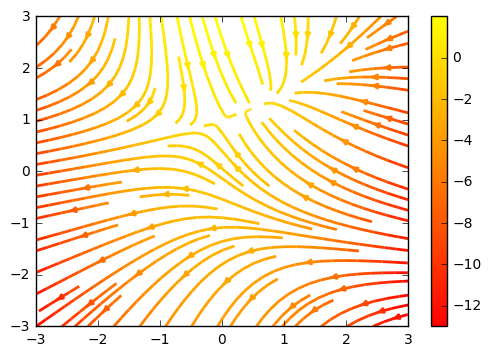

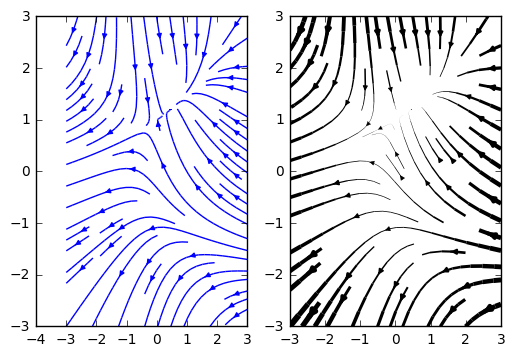

In [9]:
"""
Demo of the `streamplot` function.

A streamplot, or streamline plot, is used to display 2D vector fields. This
example shows a few features of the stream plot function:

    * Varying the color along a streamline.
    * Varying the density of streamlines.
    * Varying the line width along a stream line.
"""
import numpy as np
import matplotlib.pyplot as plt

Y, X = np.mgrid[-3:3:100j, -3:3:100j]
U = -1 - X**2 + Y
V = 1 + X - Y**2
speed = np.sqrt(U*U + V*V)

fig0, ax0 = plt.subplots()
strm = ax0.streamplot(X, Y, U, V, color=U, linewidth=2, cmap=plt.cm.autumn)
fig0.colorbar(strm.lines)

fig1, (ax1, ax2) = plt.subplots(ncols=2)
ax1.streamplot(X, Y, U, V, density=[0.5, 1])

lw = 5*speed / speed.max()
ax2.streamplot(X, Y, U, V, density=0.6, color='k', linewidth=lw)

plt.show()

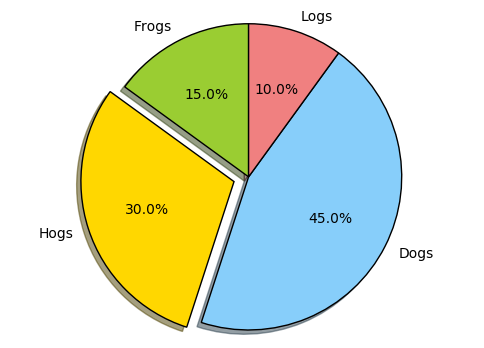

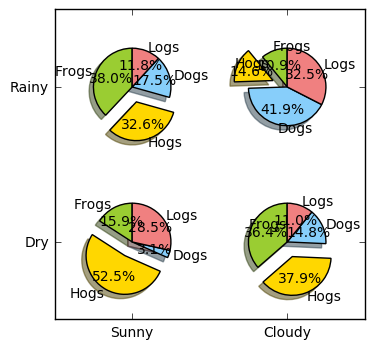

In [10]:
"""
Demo of a basic pie chart plus a few additional features.

In addition to the basic pie chart, this demo shows a few optional features:

    * slice labels
    * auto-labeling the percentage
    * offsetting a slice with "explode"
    * drop-shadow
    * custom start angle

Note about the custom start angle:

The default ``startangle`` is 0, which would start the "Frogs" slice on the
positive x-axis. This example sets ``startangle = 90`` such that everything is
rotated counter-clockwise by 90 degrees, and the frog slice starts on the
positive y-axis.
"""
import matplotlib.pyplot as plt

# The slices will be ordered and plotted counter-clockwise.
labels = 'Frogs', 'Hogs', 'Dogs', 'Logs'
sizes = [15, 30, 45, 10]
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')

fig = plt.figure()
ax = fig.gca()
import numpy as np

ax.pie(np.random.random(4), explode=explode, labels=labels, colors=colors,
       autopct='%1.1f%%', shadow=True, startangle=90,
       radius=0.25, center=(0, 0), frame=True)
ax.pie(np.random.random(4), explode=explode, labels=labels, colors=colors,
       autopct='%1.1f%%', shadow=True, startangle=90,
       radius=0.25, center=(1, 1), frame=True)
ax.pie(np.random.random(4), explode=explode, labels=labels, colors=colors,
       autopct='%1.1f%%', shadow=True, startangle=90,
       radius=0.25, center=(0, 1), frame=True)
ax.pie(np.random.random(4), explode=explode, labels=labels, colors=colors,
       autopct='%1.1f%%', shadow=True, startangle=90,
       radius=0.25, center=(1, 0), frame=True)

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["Sunny", "Cloudy"])
ax.set_yticklabels(["Dry", "Rainy"])
ax.set_xlim((-0.5, 1.5))
ax.set_ylim((-0.5, 1.5))

# Set aspect ratio to be equal so that pie is drawn as a circle.
ax.set_aspect('equal')

plt.show()


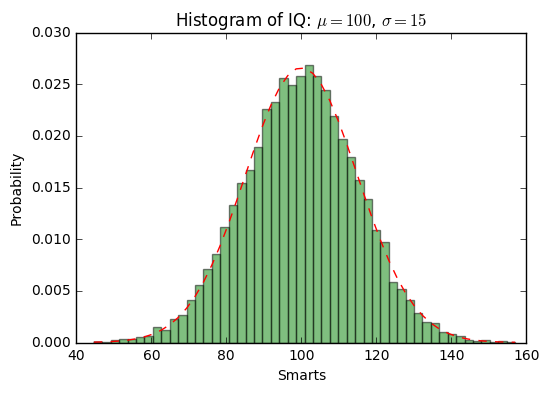

In [11]:
"""
Demo of the histogram (hist) function with a few features.

In addition to the basic histogram, this demo shows a few optional features:

    * Setting the number of data bins
    * The ``normed`` flag, which normalizes bin heights so that the integral of
      the histogram is 1. The resulting histogram is a probability density.
    * Setting the face color of the bars
    * Setting the opacity (alpha value).

"""
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt


# example data
mu = 100  # mean of distribution
sigma = 15  # standard deviation of distribution
x = mu + sigma * np.random.randn(10000)

num_bins = 50
# the histogram of the data
n, bins, patches = plt.hist(x, num_bins, normed=1, 
                            facecolor='green', alpha=0.5)
# add a 'best fit' line
y = mlab.normpdf(bins, mu, sigma)
plt.plot(bins, y, 'r--')
plt.xlabel('Smarts')
plt.ylabel('Probability')
plt.title(r'Histogram of IQ: $\mu=100$, $\sigma=15$')

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.show()

In [17]:
import os

transurl = 'transcount.csv'
gpuurl = './gpu_transcount.csv'
transurl = './transcount.csv'
os.path.exists(transurl)

True

In [6]:
import pandas as pd

pd.read_csv(transurl)

,trans_count,year
0,2600000000,2011
1,4310000000,2014
2,1000000000,2010
3,5000000000,2012
4,1200000000,2012
5,3100000000,2012
6,1200000000,2010
7,2100000000,2012
8,2300000000,2010
9,463000000,2007


       trans_count
year              
1971  2.300000e+03
1972  3.500000e+03
1974  4.533333e+03
1975  3.510000e+03
1976  7.500000e+03
1978  1.900000e+04
1979  4.850000e+04
1982  9.450000e+04
1983  8.500000e+03
1984  2.000000e+05
1985  1.053333e+05
1986  2.500000e+04
1988  2.500000e+05
1989  7.401175e+05
1991  6.900000e+05
1993  3.100000e+06
1994  5.789770e+05
1995  5.500000e+06
1996  4.300000e+06
1997  8.150000e+06
1998  7.500000e+06
1999  1.760000e+07
2000  3.150000e+07
2001  4.500000e+07
2002  1.375000e+08
2003  1.900667e+08
2004  3.520000e+08
2005  1.690000e+08
2006  6.040000e+08
2007  3.716000e+08
2008  9.032000e+08
2009  3.450000e+09
2010  1.511667e+09
2011  1.733500e+09
2012  2.014826e+09
2013  5.000000e+09
2014  4.310000e+09
Poly [  3.61559210e-01  -7.05783195e+02]


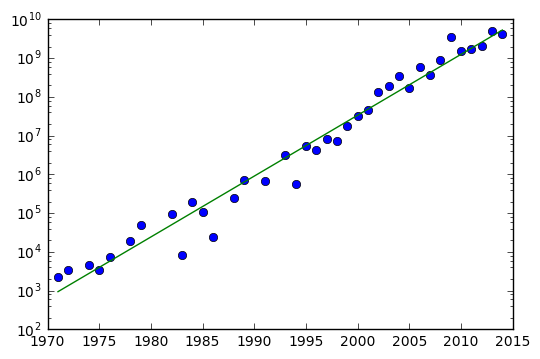

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
df = pd.read_csv(transurl)
df = df.groupby('year').aggregate(np.mean)
print(df)
years = df.index.values
counts = df['trans_count'].values
# fit the data to a + b * x 
poly = np.polyfit(years, np.log(counts), deg=1)
print("Poly", poly)
plt.semilogy(years, counts, 'o')
plt.semilogy(years, np.exp(np.polyval(poly, years)))
plt.show()

      gpu_trans_count
year                 
1997          3500000
1999         13500000
2000         25000000
2001         58500000
2002         85000000
2003        126000000
2004        191000000
2005        312000000
2006        532500000
2007        727000000
2008       1179500000
2009       2154000000
2010       2946666666
2011       4312711873
2012       5310000000
2013       6300000000
       trans_count  gpu_trans_count
year                               
1971  2.300000e+03     0.000000e+00
1972  3.500000e+03     0.000000e+00
1974  4.533333e+03     0.000000e+00
1975  3.510000e+03     0.000000e+00
1976  7.500000e+03     0.000000e+00
1978  1.900000e+04     0.000000e+00
1979  4.850000e+04     0.000000e+00
1982  9.450000e+04     0.000000e+00
1983  8.500000e+03     0.000000e+00
1984  2.000000e+05     0.000000e+00
1985  1.053333e+05     0.000000e+00
1986  2.500000e+04     0.000000e+00
1988  2.500000e+05     0.000000e+00
1989  7.401175e+05     0.000000e+00
1991  6.900000e+05     0.000

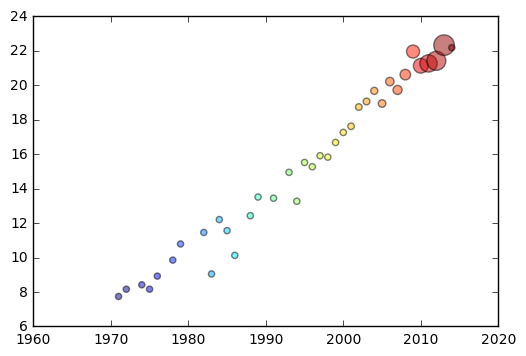

In [18]:
df = pd.read_csv(transurl)
df = df.groupby('year').aggregate(np.mean)

gpu = pd.read_csv(gpuurl)
gpu = gpu.groupby('year').aggregate(np.mean)
print(gpu)
df = pd.merge(df, gpu, how='outer', left_index=True, right_index=True)
df = df.replace(np.nan, 0)
print(df)
years = df.index.values
counts = df['trans_count'].values
gpu_counts = df['gpu_trans_count'].values
cnt_log = np.log(counts)
plt.scatter(years, cnt_log, c= 200 * years, s=20 + 200 * gpu_counts/gpu_counts.max(), alpha=0.5)
plt.show()


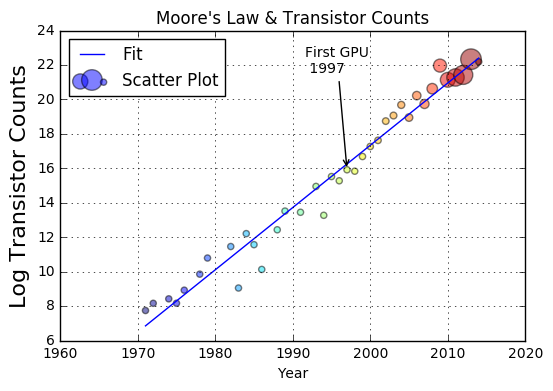

In [21]:
# Dress up the plot 

df = pd.read_csv(transurl)
df = df.groupby('year').aggregate(np.mean)

gpu = pd.read_csv(gpuurl)
gpu = gpu.groupby('year').aggregate(np.mean)

df = pd.merge(df, gpu, how='outer', left_index=True, right_index=True)
df = df.replace(np.nan, 0)
years = df.index.values
counts = df['trans_count'].values
gpu_counts = df['gpu_trans_count'].values

poly = np.polyfit(years, np.log(counts), deg=1)
plt.plot(years, np.polyval(poly, years), label='Fit')

gpu_start = gpu.index.values.min()
y_ann = np.log(df.at[gpu_start, 'trans_count'])
ann_str = "First GPU\n %d" % gpu_start
plt.annotate(ann_str, xy=(gpu_start, y_ann), arrowprops=dict(arrowstyle="->"), xytext=(-30, +70), textcoords='offset points')

cnt_log = np.log(counts)
plt.scatter(years, cnt_log, c= 200 * years, s=20 + 200 * gpu_counts/gpu_counts.max(), alpha=0.5, label="Scatter Plot")
plt.legend(loc='upper left')
plt.grid()
plt.xlabel("Year")
plt.ylabel("Log Transistor Counts", fontsize=16)
plt.title("Moore's Law & Transistor Counts")
plt.show()


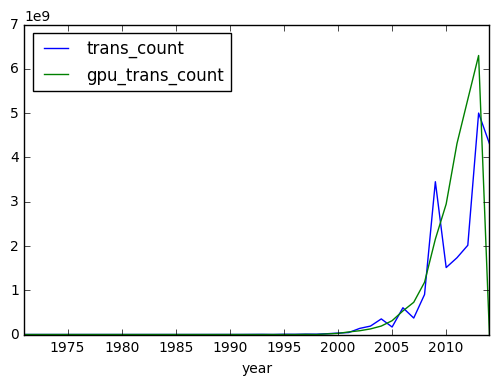

In [24]:
# quick plot right from the merged panda

df.plot()

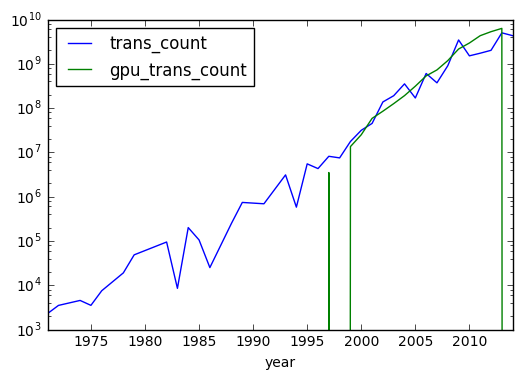

In [25]:
# make it a log plot

df.plot(logy=True)

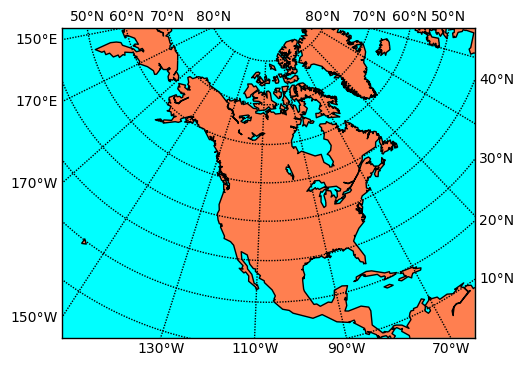

In [27]:
%matplotlib inline

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
# setup Lambert Conformal basemap.
m = Basemap(width=12000000,height=9000000,projection='lcc',
            resolution='c',lat_1=45.,lat_2=55,lat_0=50,lon_0=-107.)
# draw coastlines.
m.drawcoastlines()
# draw a boundary around the map, fill the background.
# this background will end up being the ocean color, since
# the continents will be drawn on top.
m.drawmapboundary(fill_color='aqua')
# fill continents, set lake color same as ocean color.
m.fillcontinents(color='coral',lake_color='aqua')
# draw parallels and meridians.
# label parallels on right and top
# meridians on bottom and left
parallels = np.arange(0.,81,10.)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,True,True,False])
meridians = np.arange(10.,351.,20.)
m.drawmeridians(meridians,labels=[True,False,False,True])
plt.show()


In [29]:
#  broken

%matplotlib inline

from mpl_toolkits.basemap import Basemap, shiftgrid, cm
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset

# read in etopo5 topography/bathymetry.
url = 'http://ferret.pmel.noaa.gov/thredds/dodsC/data/PMEL/etopo5.nc'
etopodata = Dataset(url)

topoin = etopodata.variables['ROSE'][:]
lons = etopodata.variables['ETOPO05_X'][:]
lats = etopodata.variables['ETOPO05_Y'][:]
# shift data so lons go from -180 to 180 instead of 20 to 380.
topoin,lons = shiftgrid(180.,topoin,lons,start=False)

# plot topography/bathymetry as an image.

# create the figure and axes instances.
fig = plt.figure()
ax = fig.add_axes([0.1,0.1,0.8,0.8])
# setup of basemap ('lcc' = lambert conformal conic).
# use major and minor sphere radii from WGS84 ellipsoid.
m = Basemap(llcrnrlon=-145.5,llcrnrlat=1.,urcrnrlon=-2.566,urcrnrlat=46.352,\
            rsphere=(6378137.00,6356752.3142),\
            resolution='l',area_thresh=1000.,projection='lcc',\
            lat_1=50.,lon_0=-107.,ax=ax)
# transform to nx x ny regularly spaced 5km native projection grid
nx = int((m.xmax-m.xmin)/5000.)+1; ny = int((m.ymax-m.ymin)/5000.)+1
topodat = m.transform_scalar(topoin,lons,lats,nx,ny)
# plot image over map with imshow.
im = m.imshow(topodat,cm.GMT_haxby)
# draw coastlines and political boundaries.
m.drawcoastlines()
m.drawcountries()
m.drawstates()
# draw parallels and meridians.
# label on left and bottom of map.
parallels = np.arange(0.,80,20.)
m.drawparallels(parallels,labels=[1,0,0,1])
meridians = np.arange(10.,360.,30.)
m.drawmeridians(meridians,labels=[1,0,0,1])
# add colorbar
cb = m.colorbar(im,"right", size="5%", pad='2%')
ax.set_title('ETOPO5 Topography - Lambert Conformal Conic')
plt.show()

ImportError: dlopen(/Users/lstead/anaconda/lib/python3.5/site-packages/netCDF4/_netCDF4.so, 2): Library not loaded: @rpath/libmfhdf.0.dylib
  Referenced from: /Users/lstead/anaconda/lib/libnetcdf.11.dylib
  Reason: image not found